In [1]:
import pandas as pd
import matplotlib.pyplot as plt

# change to path to where "data_mapping_filtered.csv" is
data_path = f"../make_data/data_mapping_filtered.csv"
# Ensure to include 'ships_idx' in the fields list
fields = ['ships_idx', 'tag_name', 'tag_description', 'thing', 'property']

# Load the dataset
try:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields)
except UnicodeDecodeError:
    df = pd.read_csv(data_path, skipinitialspace=True, usecols=fields, encoding='ISO-8859-1')



## Problem: sample by ships_idx while maintaining overall row count proportion

To illustrate the problem: splitting by ship_idx alone might not lead to fair distribution of observation count since ship_idx do not share uniform counts. 

If sampling is bad, ships 1,29,31,2001,2003 in the same group might lead to a severe undercount for that splitted group.

We have to perform our own sampling based on the overall proportion of counts in the group

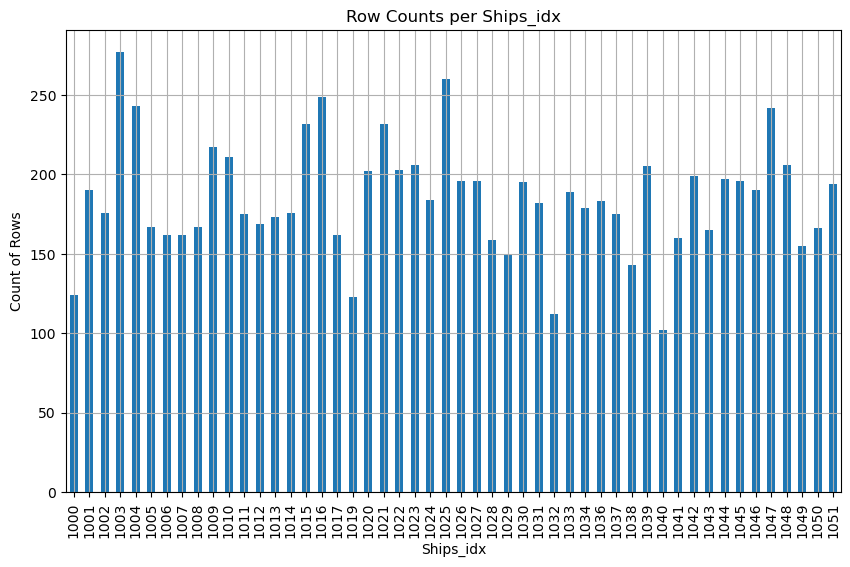

In [2]:
# Group the data by 'ships_idx' and count the rows for each group
row_counts = df.groupby('ships_idx').size()

# Plotting
plt.figure(figsize=(10, 6))  # Adjust the size of the figure as needed
row_counts.plot(kind='bar')  # You can also use 'barh' for a horizontal bar plot
plt.title('Row Counts per Ships_idx')
plt.xlabel('Ships_idx')
plt.ylabel('Count of Rows')
plt.grid(True)
plt.show()


In [3]:
total_counts = sum(row_counts)
print(total_counts)

9278


In [4]:
import random


# function purpose: randomly sample until total counts hit the required proportion
# argument 1: dictionary of ship_idx to count
# argument 2: target proportion of total counts in argument 1
# argument 3: seed for random generator
def sample_idx_until_proportion(count_by_ship_idx, target_proportion, seed):

    random.seed(seed)
    ship_idx_list = list(count_by_ship_idx.keys())

    total_count = sum(count_by_ship_idx.values())
    target_count = int(total_count * target_proportion)

    selected_ships = []
    total_selected_counts = 0

    # sample ship_idx until counts are close enough to target
    # add a buffer of 100 to stop once close enough
    while (total_selected_counts < target_count - 100): 
        
        # Select a ship using random sampling without replacement
        chosen_ship_idx = random.choice(ship_idx_list)
        counts = count_by_ship_idx[chosen_ship_idx]
        
        # Add the chosen ship to the selected ship list
        selected_ships.append(chosen_ship_idx)
        total_selected_counts += counts

        # remove selected ship from sampling list
        ship_idx_list.remove(chosen_ship_idx)
    return selected_ships, total_selected_counts
    

In [5]:
seed = 43
count_by_ship_idx = df.groupby('ships_idx').size().to_dict()

total_ship_idx_set = set(count_by_ship_idx.keys())
# sample idx's for training data
# since this data is only used for training, we want to maximize training set
training_ship_idx_selection, training_counts = sample_idx_until_proportion(count_by_ship_idx, 0.95, seed=seed)
val_test_ship_idx_set = total_ship_idx_set - set(training_ship_idx_selection)
# sample idx's for validation data
count_by_ship_idx_val_test_set = { ship_idx: count_by_ship_idx[ship_idx] for ship_idx in list(val_test_ship_idx_set) }
# note that 0.5 is for the ship_idx set that remains after removing training ship_idx's
# set to 1.0 to fully set no ships for test
# we want to maximize the full training data set
val_ship_idx_selection, validation_counts = sample_idx_until_proportion(count_by_ship_idx_val_test_set, 1.0, seed=seed)
# sample idx's for test data
test_ship_idx_selection = val_test_ship_idx_set - set(val_ship_idx_selection)

# get report of split
total_counts = sum(count_by_ship_idx.values())
print("training proportion: ", training_counts/total_counts)
print("validation proportion: ", validation_counts/total_counts)
print("test proportion: ", (total_counts - training_counts - validation_counts)/total_counts)


print("training ship idx selection:")
print(training_ship_idx_selection)

print("validation ship idx selection:")
print(val_ship_idx_selection)

print("training ship idx selection:")
print(test_ship_idx_selection)

train_idx = training_ship_idx_selection
test_idx = test_ship_idx_selection
validation_idx = val_ship_idx_selection

training proportion:  0.9464324207803406
validation proportion:  0.05356757921965941
test proportion:  0.0
training ship idx selection:
[1002, 1020, 1048, 1010, 1033, 1027, 1050, 1007, 1037, 1047, 1040, 1051, 1001, 1043, 1036, 1030, 1039, 1034, 1015, 1003, 1045, 1006, 1046, 1008, 1022, 1011, 1009, 1014, 1032, 1031, 1013, 1028, 1044, 1023, 1017, 1021, 1004, 1000, 1041, 1005, 1019, 1012, 1025, 1026, 1029, 1016, 1024]
validation ship idx selection:
[1049, 1038, 1042]
training ship idx selection:
set()


# process tag_description

we want to add special marker tokens flanking the '#' of the MDM

In [7]:
tag_desc = df['tag_description'].to_list()

In [8]:
tag_desc

['M/E LOAD ',
 'M/E RPM SIGNAL',
 'M/E T/C RPM',
 'M/E T/C L.O INLET PRESS L / SLOWDOWN',
 'M/E F.O INLET PRESS L',
 'ME RPM',
 'M/E MAIN LO INLET PRESS',
 'M/E MAIN LO INLET TEMP',
 'M/E JACKET C.F.W INLET PRESS L / SLOW DOWN',
 'M/E SCAV. AIR RECEIVER PRESS ',
 'M/E L.O INLET TO MAIN BRG & THR. BRG PRESS L / SLOWDOWN',
 'M/E NO.1 CYL. EXH GAS OUTLET TEMP H',
 'M/E T/C LO INLET TEMP',
 'M/E T/C LO INLET PRESS',
 'M/E T/C LO OUTLET TEMP',
 'ME 1 CYL PCO OUTLET TEMP',
 'M/E NO.2 CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.3 CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.4 CYL. EXH GAS OUTLET TEMP H',
 'M/E NO.5 CYL. EXH GAS OUTLET TEMP H',
 'ME 2 CYL PCO OUTLET TEMP',
 'ME 3 CYL PCO OUTLET TEMP',
 'M/E NO.6 CYL. EXH GAS OUTLET TEMP H',
 'M/E T/C EXH GAS INLET TEMP H',
 'M/E T/C EXH GAS OUTLET TEMP H',
 'M/E T/C L.O OUTLET TEMP H',
 'M/E SCAV. AIR RECEIVER TEMP H',
 'M/E NO.1 CYL. COVER C.W. OUTLET TEMP H',
 'M/E NO.2 CYL. COVER C.W. OUTLET TEMP H',
 'M/E NO.3 CYL. COVER C.W. OUTLET TEMP H',
 'M/E NO.4

In [25]:
import difflib

# good case

case_a  = 'M/E NO.1 PISTON C.O OUTLET TEMP'

case_b  = 'M/E NO.2 PISTON C.O OUTLET TEMP'

output_list = [li for li in difflib.ndiff(case_a, case_b) if li[0] != ' ']
print(output_list)

['1', '2']


In [ ]:
# bad case
case_a = ' EXH GAS TEMP AT TURBINE O TC <attn1>1<attn1>'
case_b = ' EXH GAS TEMP AT TURBINE OUT TC <attn1>1<attn1>'
diff_list = [li for li in difflib.ndiff(case_a, case_b) if li[0] != ' ']
diff_list


['+ U', '+ T']

In [ ]:
# the reason for this function is when only 1 character differs,
# there should only be 1 char from case_a (plus) and 1 char from case_b (minus)
def check_num_of_plus_and_minus(diff_list):
    # Initialize counters for '+' and '-' signs
    plus_count = 0
    minus_count = 0

    # Iterate over each string in the list
    for item in diff_list:
        # Count the occurrences of '+' and '-' signs in the string
        plus_count += item[:1].count('+')
        minus_count += item[:1].count('-')
    if (plus_count == 1) and (minus_count == 1):
        return True
    else:
        return False

In [ ]:
# a simple rule is to use the list comprehension and find if the difference is only 2 characters, 
# this function returns all the indices that belong to a common set of sequences
def find_single_char_diff(tag_desc):
    seq_started = False
    seq_index = -1 # add 1 to become 0 when start of new seq
    output_list = []
    for i in range(0,len(tag_desc) - 2):
        case_a = tag_desc[i]
        case_b = tag_desc[i + 1]
        diff_list = [li for li in difflib.ndiff(case_a, case_b) if li[0] != ' ']
        # start of new sequence
        if check_num_of_plus_and_minus(diff_list) and (not seq_started):
            seq_started = True
            # create new nested list
            output_list.append([])
            # create new sequence index
            seq_index = seq_index + 1

        # check for end of sequence
        if (not check_num_of_plus_and_minus(diff_list)) and (seq_started):
            seq_started = False
            # add last element
            output_list[seq_index].append(i)

        # if still seq_started even after check for end of sequence, then add 
        if seq_started:
            output_list[seq_index].append(i)
    return output_list

obj_families_index = find_single_char_diff(tag_desc)

In [12]:
obj_families_index = find_single_char_diff(tag_desc)

In [13]:
# obj_families_index

In [14]:
def find_index_of_difference(str1, str2):
    # Iterate through the characters of the strings
    for i, (char1, char2) in enumerate(zip(str1, str2)):
        if char1 != char2:
            return i  # Return the index where the characters differ

    # If no difference found, return -1 (or any other suitable value)
    return -1

# perform attention token insertion for each word at the same index for a given family
# note: we are guaranteed that the tokens differ only at a position
for family in obj_families_index:
    # identify which position to insert the special token at
    position = find_index_of_difference(tag_desc[family[0]], tag_desc[family[1]])
    # then insert token into every word in the family
    for word_index in family:
        # Slice the original string into two parts at the specified position
        word = tag_desc[word_index]
        part1 = word[:position]
        part2 = word[position]
        part3 = word[position + 1:]
        tag_desc[word_index] = part1 + "<attn1>" + part2 + "<attn1>" + part3


In [15]:
obj_families = [[tag_desc[i] for i in index_group] for index_group in obj_families_index]

# you can print obj_families to check - it looks fine to me


In [18]:

obj_families

[['M/E NO.<attn1>2<attn1> CYL. EXH GAS OUTLET TEMP H',
  'M/E NO.<attn1>3<attn1> CYL. EXH GAS OUTLET TEMP H',
  'M/E NO.<attn1>4<attn1> CYL. EXH GAS OUTLET TEMP H',
  'M/E NO.<attn1>5<attn1> CYL. EXH GAS OUTLET TEMP H'],
 ['ME <attn1>2<attn1> CYL PCO OUTLET TEMP',
  'ME <attn1>3<attn1> CYL PCO OUTLET TEMP'],
 ['M/E NO.<attn1>1<attn1> CYL. COVER C.W. OUTLET TEMP H',
  'M/E NO.<attn1>2<attn1> CYL. COVER C.W. OUTLET TEMP H',
  'M/E NO.<attn1>3<attn1> CYL. COVER C.W. OUTLET TEMP H',
  'M/E NO.<attn1>4<attn1> CYL. COVER C.W. OUTLET TEMP H',
  'M/E NO.<attn1>5<attn1> CYL. COVER C.W. OUTLET TEMP H',
  'M/E NO.<attn1>6<attn1> CYL. COVER C.W. OUTLET TEMP H'],
 ['M/E NO.<attn1>1<attn1> PCO OUTLET TEMP H',
  'M/E NO.<attn1>2<attn1> PCO OUTLET TEMP H',
  'M/E NO.<attn1>3<attn1> PCO OUTLET TEMP H',
  'M/E NO.<attn1>4<attn1> PCO OUTLET TEMP H',
  'M/E NO.<attn1>5<attn1> PCO OUTLET TEMP H',
  'M/E NO.<attn1>6<attn1> PCO OUTLET TEMP H'],
 ['NO.<attn1>1<attn1> G/E SPEED',
  'NO.<attn1>2<attn1> G/E SPEE

The above shows a peculiar observation: it is possible for 2 lists to have another 1 char difference in corresponding elements

I can run another round of 1 char difference, and then join the 2 lists together if the first element of 2 lists has only 1 char difference

# perform 2nd round of 1-char diff

This time we choose the first string of each family and compare them

This is a very simple idea, but could go wrong if the sorted order is a bit different from the regular pattern

e.g.

start of family1: sequence1A

start of family2: sequence2B instead of sequence 2A


In [19]:
# take only the first char of each list
input_list = [family[0] for family in obj_families]
families_index_2 = find_single_char_diff(input_list)

In [20]:
[obj_families[i] for i in families_index_2[0]]

[['NO.1 GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.1 GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.1 GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.2 GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.2 GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.2 GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.5 GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.5 GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.5 GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.3 GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.3 GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.3 GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.4 GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.4 GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.4 GEN. WINDING TEMP <attn1>W<attn1>1']]

In [21]:
print(families_index_2[0])
# grab the first word
family_2 = families_index_2[0]
# grab a family from the family of families
print(obj_families[family_2[0]])
# grab the first word of the chosen family
print(obj_families[family_2[0]][0])


[8, 9, 10, 11, 12]
['NO.1 GEN. WINDING TEMP <attn1>U<attn1>1', 'NO.1 GEN. WINDING TEMP <attn1>V<attn1>1', 'NO.1 GEN. WINDING TEMP <attn1>W<attn1>1']
NO.1 GEN. WINDING TEMP <attn1>U<attn1>1


In [22]:
# perform attention token insertion for each word at the same index for a given family
# note: we are guaranteed that the tokens differ only at a position
for family_2 in families_index_2:
    # identify which position to insert the special token at
    position = find_index_of_difference(obj_families[family_2[0]][0], obj_families[family_2[1]][0])
    # then insert token into every word in the family of families (family_2)
    for family_index in family_2:
        for word_index in obj_families_index[family_index]:
            # Slice the original string into two parts at the specified position
            word = tag_desc[word_index]
            part1 = word[:position]
            part2 = word[position]
            part3 = word[position + 1:]
            tag_desc[word_index] = part1 + "<attn2>" + part2 + "<attn2>" + part3


In [23]:
obj_families = [[tag_desc[i] for i in index_group] for index_group in obj_families_index]

# you can print obj_families to check - it looks fine to me
for i in families_index_2[0]:
    print(obj_families[i])

['NO.<attn2>1<attn2> GEN. WINDING TEMP <attn1>U<attn1>1', 'NO.<attn2>1<attn2> GEN. WINDING TEMP <attn1>V<attn1>1', 'NO.<attn2>1<attn2> GEN. WINDING TEMP <attn1>W<attn1>1']
['NO.<attn2>2<attn2> GEN. WINDING TEMP <attn1>U<attn1>1', 'NO.<attn2>2<attn2> GEN. WINDING TEMP <attn1>V<attn1>1', 'NO.<attn2>2<attn2> GEN. WINDING TEMP <attn1>W<attn1>1']
['NO.<attn2>5<attn2> GEN. WINDING TEMP <attn1>U<attn1>1', 'NO.<attn2>5<attn2> GEN. WINDING TEMP <attn1>V<attn1>1', 'NO.<attn2>5<attn2> GEN. WINDING TEMP <attn1>W<attn1>1']
['NO.<attn2>3<attn2> GEN. WINDING TEMP <attn1>U<attn1>1', 'NO.<attn2>3<attn2> GEN. WINDING TEMP <attn1>V<attn1>1', 'NO.<attn2>3<attn2> GEN. WINDING TEMP <attn1>W<attn1>1']
['NO.<attn2>4<attn2> GEN. WINDING TEMP <attn1>U<attn1>1', 'NO.<attn2>4<attn2> GEN. WINDING TEMP <attn1>V<attn1>1', 'NO.<attn2>4<attn2> GEN. WINDING TEMP <attn1>W<attn1>1']


In [24]:
[obj_families[i] for i in families_index_2[0]]

[['NO.<attn2>1<attn2> GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.<attn2>1<attn2> GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.<attn2>1<attn2> GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.<attn2>2<attn2> GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.<attn2>2<attn2> GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.<attn2>2<attn2> GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.<attn2>5<attn2> GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.<attn2>5<attn2> GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.<attn2>5<attn2> GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.<attn2>3<attn2> GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.<attn2>3<attn2> GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.<attn2>3<attn2> GEN. WINDING TEMP <attn1>W<attn1>1'],
 ['NO.<attn2>4<attn2> GEN. WINDING TEMP <attn1>U<attn1>1',
  'NO.<attn2>4<attn2> GEN. WINDING TEMP <attn1>V<attn1>1',
  'NO.<attn2>4<attn2> GEN. WINDING TEMP <attn1>W<attn1>1']]

In [124]:
# save result back to df
new_df = pd.DataFrame({'tag_description_with_tokens': tag_desc})
df = pd.concat([df, new_df], axis=1)
df['tag_description_with_tokens'] = df['tag_description_with_tokens'].astype('string')




In [125]:
df.columns

Index(['thing', 'property', 'ships_idx', 'tag_name', 'tag_description',
       'tag_description_with_tokens'],
      dtype='object')

# produce columnar data to disk

In [126]:
# Filter the DataFrame based on the split indices
train_df = df[df['ships_idx'].isin(train_idx)]
# test_df = df[df['ships_idx'].isin(test_idx)]
validation_df = df[df['ships_idx'].isin(validation_idx)]


In [127]:
import json
from datasets import Dataset, DatasetDict


# convert each dataframe row into a dictionary
# outputs a list of dictionaries
def process_df(df):
    output_list = [{
        'translation': {
            'ships_idx': row['ships_idx'],
            'tag_description': row['tag_description_with_tokens'],
            'thing_property': f"<THING_START>{row['thing']}<THING_END><PROPERTY_START>{row['property']}<PROPERTY_END>",
            'answer': f"{row['thing']} {row['property']}",

        }
    } for _, row in df.iterrows()]

    return output_list


combined_data = DatasetDict({
    'train': Dataset.from_list(process_df(train_df)),
    # 'test' : Dataset.from_list(process_df(test_df)),
    'validation' : Dataset.from_list(process_df(validation_df)),
})



combined_data.save_to_disk("combined_data")

Saving the dataset (0/1 shards):   0%|          | 0/8781 [00:00<?, ? examples/s]

Saving the dataset (0/1 shards):   0%|          | 0/497 [00:00<?, ? examples/s]